In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import average_precision_score, f1_score
from sklearn.metrics import precision_recall_curve, auc, roc_auc_score, f1_score, confusion_matrix, plot_precision_recall_curve

import warnings
warnings.filterwarnings('ignore')

### Load Data

In [2]:
df = pd.read_csv('meps_base_data.csv').drop('Unnamed: 0', axis=1)
df.head()

,id,panel,pooledWeight,age,sex,race,married,highBPDiagnosed,diabetesDiagnosed,chdDiagnosed,miDiagnosed,anginaDiagnosed,strokeDiagnosed,emphysemaDiagnosed,asthmaDiagnosed,otherHDDiagnosed,heartFailureDiagnosed
0,10007101,15,3603.881236,28,Male,White,MARRIED,Yes,No,No,No,No,No,No,No,No,No
1,10007102,15,2544.550424,25,Female,White,MARRIED,No,No,No,No,No,No,No,Yes,No,No
2,10007103,15,4050.397468,4,Male,White,UNDER 16 - INAPPLICABLE,Inapplicable,Inapplicable,Inapplicable,Inapplicable,Inapplicable,Inapplicable,Inapplicable,No,Inapplicable,No
3,10007104,15,3064.059720,3,Female,White,UNDER 16 - INAPPLICABLE,Inapplicable,Inapplicable,Inapplicable,Inapplicable,Inapplicable,Inapplicable,Inapplicable,No,Inapplicable,No
4,10008101,15,3635.552466,51,Male,Multiple,MARRIED,No,No,No,No,No,No,No,No,No,No


In [3]:
med = pd.read_csv('meps_meds.csv').drop('Unnamed: 0', axis=1)
med.head()

,id,rxStartMonth,rxStartYear,rxName,rxNDC,rxQuantity,rxForm
0,10007104,3,2011,AMOXICILLIN,143988775,75.0,SUSR
1,10007104,3,2011,OTIC EDGE SOLUTION,68032032814,14.0,SOL
2,10008102,3,2011,NASAL DECONGESTANT 0.05% SPRAY,63981056903,15.0,SPR
3,10008102,3,2011,NASAL DECONGESTANT 0.05% SPRAY,63981056903,15.0,SPR
4,10008102,9,2011,DIPHENHYDRAM,603333921,30.0,CAP


### Data Quality Check

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61489 entries, 0 to 61488
Data columns (total 17 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     61489 non-null  int64  
 1   panel                  61489 non-null  int64  
 2   pooledWeight           61489 non-null  float64
 3   age                    61489 non-null  int64  
 4   sex                    61489 non-null  object 
 5   race                   61489 non-null  object 
 6   married                61489 non-null  object 
 7   highBPDiagnosed        61489 non-null  object 
 8   diabetesDiagnosed      61489 non-null  object 
 9   chdDiagnosed           61489 non-null  object 
 10  miDiagnosed            61489 non-null  object 
 11  anginaDiagnosed        61489 non-null  object 
 12  strokeDiagnosed        61489 non-null  object 
 13  emphysemaDiagnosed     61489 non-null  object 
 14  asthmaDiagnosed        61489 non-null  object 
 15  ot

In [5]:
print('counting unique members:', df.id.nunique())

counting unique members: 61489


In [6]:
med.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1148347 entries, 0 to 1148346
Data columns (total 7 columns):
 #   Column        Non-Null Count    Dtype  
---  ------        --------------    -----  
 0   id            1148347 non-null  int64  
 1   rxStartMonth  1148347 non-null  int64  
 2   rxStartYear   1148347 non-null  int64  
 3   rxName        1148347 non-null  object 
 4   rxNDC         1148347 non-null  int64  
 5   rxQuantity    1148347 non-null  float64
 6   rxForm        1148347 non-null  object 
dtypes: float64(1), int64(4), object(2)
memory usage: 61.3+ MB


In [7]:
# assume duplicates when all attributes are the same
print('Checking duplicates: ', len(med.drop_duplicates()) == len(med))

# drop duplicates
print('remove duplicates')
med.drop_duplicates(inplace=True, ignore_index=True)
print('Checking duplicates: ', len(med.drop_duplicates()) == len(med))

Checking duplicates:  False
remove duplicates
Checking duplicates:  True


In [8]:
print('Negative Rx Quantity:', sum(med.rxQuantity < 0))

# drop negative rx quantity records
print('remove negative rx quantity')
med = med[med.rxQuantity > 0]
print('Negative Rx Quantity:', sum(med.rxQuantity < 0))

Negative Rx Quantity: 149
remove negative rx quantity
Negative Rx Quantity: 0


### Preprocessing Data

In [9]:
def transform_numeric(x):
    
    if x == 'Yes':
        return 1
    elif x == 'No':
        return 0
    else:
        return -1
    
df['highBP'] = df.highBPDiagnosed.map(transform_numeric)
df['diabetes'] = df.diabetesDiagnosed.map(transform_numeric)
df['chd'] = df.chdDiagnosed.map(transform_numeric)
df['mi'] = df.miDiagnosed.map(transform_numeric)
df['angina'] = df.anginaDiagnosed.map(transform_numeric)
df['stroke'] = df.strokeDiagnosed.map(transform_numeric)
df['emphysema'] = df.emphysemaDiagnosed.map(transform_numeric)
df['asthma'] = df.asthmaDiagnosed.map(transform_numeric)
df['otherHD'] = df.otherHDDiagnosed.map(transform_numeric)
df['heartFailure'] = df.heartFailureDiagnosed.map(transform_numeric)
df.head()

,id,panel,pooledWeight,age,sex,race,married,highBPDiagnosed,diabetesDiagnosed,chdDiagnosed,...,highBP,diabetes,chd,mi,angina,stroke,emphysema,asthma,otherHD,heartFailure
0,10007101,15,3603.881236,28,Male,White,MARRIED,Yes,No,No,...,1,0,0,0,0,0,0,0,0,0
1,10007102,15,2544.550424,25,Female,White,MARRIED,No,No,No,...,0,0,0,0,0,0,0,1,0,0
2,10007103,15,4050.397468,4,Male,White,UNDER 16 - INAPPLICABLE,Inapplicable,Inapplicable,Inapplicable,...,-1,-1,-1,-1,-1,-1,-1,0,-1,0
3,10007104,15,3064.059720,3,Female,White,UNDER 16 - INAPPLICABLE,Inapplicable,Inapplicable,Inapplicable,...,-1,-1,-1,-1,-1,-1,-1,0,-1,0
4,10008101,15,3635.552466,51,Male,Multiple,MARRIED,No,No,No,...,0,0,0,0,0,0,0,0,0,0


In [10]:
# fix negative Month and Year
med['rxStartMonth'] = abs(med.rxStartMonth)
med['rxStartYear'] = abs(med.rxStartYear)
med.head()

,id,rxStartMonth,rxStartYear,rxName,rxNDC,rxQuantity,rxForm
0,10007104,3,2011,AMOXICILLIN,143988775,75.0,SUSR
1,10007104,3,2011,OTIC EDGE SOLUTION,68032032814,14.0,SOL
2,10008102,3,2011,NASAL DECONGESTANT 0.05% SPRAY,63981056903,15.0,SPR
3,10008102,9,2011,DIPHENHYDRAM,603333921,30.0,CAP
4,10008102,9,2011,CHLD ALLERGY,24385037926,100.0,LIQD


### What are the most common medications for each disease in the base file?

In [11]:
# Pivot disease columns into one category
temp = df[['id', 'highBP', 'diabetes', 'chd', 'mi', 'angina', 'stroke', 'emphysema', 'asthma', 'otherHD', 'heartFailure']].set_index('id').stack().reset_index()
temp.columns = ['id', 'disease', 'status']

# merge medication and disease
med_dis = pd.merge(temp.query('status == 1'), med[['id', 'rxName']], left_on='id', right_on='id', how='inner')
med_dis.columns = ['id', 'disease', 'status', 'medication']
med_dis.head()

,id,disease,status,medication
0,10007101,highBP,1,ATENOLOL
1,10007101,highBP,1,AZITHROMYCIN
2,10007101,highBP,1,ATENOLOL
3,10007102,asthma,1,TREXIMET
4,10007102,asthma,1,HYDROCO/APAP


In [12]:
# count the number of medications for each disease 
Q1 = med_dis.groupby(['disease', 'medication']).id.count().reset_index()
Q1.columns = ['disease', 'medication', 'counts']

# select the most common medication for each disease
Q1.sort_values('counts', ascending = False).groupby(['disease']).head(1)

,disease,medication,counts
22324,highBP,LISINOPRIL,8074
12945,diabetes,METFORMIN,3389
30350,otherHD,LISINOPRIL,2050
2741,asthma,ALBUTEROL,1998
8839,chd,LISINOPRIL,1712
26767,mi,LISINOPRIL,1273
33931,stroke,LISINOPRIL,995
1364,angina,LISINOPRIL,748
17890,heartFailure,FUROSEMIDE,695
16133,emphysema,LISINOPRIL,530


### Question: What medications are most indicative of each disease?



In [13]:
# Pivot disease columns into one category
temp = df[['id', 'highBP', 'diabetes', 'chd', 'mi', 'angina', 'stroke', 'emphysema', 'asthma', 'otherHD', 'heartFailure']].set_index('id').stack().reset_index()
temp.columns = ['id', 'disease', 'status']

# merge medication and disease
med_dis = pd.merge(temp.query('status == 1'), med[['id', 'rxName']], left_on='id', right_on='id', how='inner')
med_dis.columns = ['id', 'disease', 'status', 'medication']
med_dis.head()

,id,disease,status,medication
0,10007101,highBP,1,ATENOLOL
1,10007101,highBP,1,AZITHROMYCIN
2,10007101,highBP,1,ATENOLOL
3,10007102,asthma,1,TREXIMET
4,10007102,asthma,1,HYDROCO/APAP


In [15]:
# calculate idf of medication
n = med_dis.disease.nunique()
idf = med_dis.groupby(['medication']).id.count().reset_index()
idf['idf'] = np.log(1+n/idf.id)
idf.columns = ['medication', 'counts', 'idf']

# calculate tf of medication
Q2 = med_dis.groupby(['disease', 'medication']).id.count().reset_index()
Q2.columns = ['disease', 'medication', 'tf']

# combine and calculate indicative rate and tf-idf
Q2 = pd.merge(Q2, idf, left_on = 'medication', right_on = 'medication', how='inner')
Q2.eval('tf_idf = tf * idf', inplace=True)
Q2.eval('indicative_rate = tf / counts', inplace=True)
Q2.query('tf >= 50 and counts <= 500').sort_values(['indicative_rate', 'tf_idf'], ascending = False).groupby(['disease']).head(1)

,disease,medication,tf,counts,idf,tf_idf,indicative_rate
20886,highBP,ZIAC,54,70,0.133531,7.210695,0.771429
29286,asthma,VYVANSE,51,69,0.135341,6.902409,0.739130
14658,diabetes,ONETOUCH ULTRA 2 BLOOD GLUCOSE MONI,101,220,0.044452,4.489628,0.459091
622,stroke,AGGRENOX,119,407,0.024273,2.888491,0.292383
18100,otherHD,SOTALOL HCL,60,245,0.040005,2.400320,0.244898
13790,chd,NITROQUICK,50,272,0.036105,1.805250,0.183824
18937,emphysema,THEOPHYLLINE,66,383,0.025775,1.701125,0.172324
17041,angina,RANEXA,59,379,0.026043,1.536545,0.155673
17048,mi,RANEXA,51,379,0.026043,1.328200,0.134565


### Question: Choose diabetes and build a model to infer whether that disease is present from the medications.

#### Data Gathering

In [36]:
# select diabetes member list
mem_demo = df.query('diabetes >= 0')[['id', 'pooledWeight', 'age', 'sex', 'race', 'married', 'highBP', 'diabetes']].set_index('id')
mem_demo.head()

,pooledWeight,age,sex,race,married,highBP,diabetes
id,,,,,,,
10007101,3603.881236,28,Male,White,MARRIED,1,0
10007102,2544.550424,25,Female,White,MARRIED,0,0
10008101,3635.552466,51,Male,Multiple,MARRIED,0,0
10008102,4367.816253,53,Female,Asian,MARRIED,0,0
10009101,6241.938280,61,Female,Black,NEVER MARRIED,1,0


In [37]:
# aggregate average medication quantity
drug_quant = med.groupby('id').rxQuantity.agg('mean')
drug_quant.head()

id
10007101    50.000000
10007102    16.000000
10007103     3.000000
10007104    44.500000
10008102    48.333333
Name: rxQuantity, dtype: float64

In [44]:
# select top 100 common diabetes medications
top_diab_drug = Q1.query('disease == "diabetes"').sort_values('counts', ascending=False).head(100).medication.values

# construct bag-of-word top diabetes medications
# create one-hot-encoder
encoder = OneHotEncoder(categories='auto', sparse=False, handle_unknown='ignore')
encoder.fit(top_diab_drug.reshape(-1,1))
encoder_feature = [i.replace('x0_', '') for i in encoder.get_feature_names()]

# aggreate medication counts by id
mem_drug = pd.DataFrame(encoder.transform(med.rxName.values.reshape(-1,1)), index=med.id, columns=encoder_feature).groupby('id').agg('sum')
mem_drug.head()

,ACCU-CHEK,ACETAMINOPHEN-HYDROCODONE BITARTRATE,ACTOS,ALBUTEROL,ALLOPURINOL,ALPRAZOLAM,AMLODIPINE,AMLODIPINE BESYLATE,AMOXICILLIN,APAP/HYDROCODONE BITARTRATE,...,SYNTHROID,TRAMADOL HCL,TRICOR,TRUETRACK,TRUETRACK SMART SYSTEM (MONITOR),VYTORIN,WARFARIN,WARFARIN SODIUM,XALATAN,ZETIA
id,,,,,,,,,,,,,,,,,,,,,
10007101,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10007102,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10007103,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10007104,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10008102,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [45]:
temp = pd.merge(mem_demo, drug_quant, left_index=True, right_index=True, how='inner')
data = pd.merge(temp, mem_drug, left_index=True, right_index=True, how='inner')
data.head()

,pooledWeight,age,sex,race,married,highBP,diabetes,rxQuantity,ACCU-CHEK,ACETAMINOPHEN-HYDROCODONE BITARTRATE,...,SYNTHROID,TRAMADOL HCL,TRICOR,TRUETRACK,TRUETRACK SMART SYSTEM (MONITOR),VYTORIN,WARFARIN,WARFARIN SODIUM,XALATAN,ZETIA
id,,,,,,,,,,,,,,,,,,,,,
10007101,3603.881236,28,Male,White,MARRIED,1,0,50.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10007102,2544.550424,25,Female,White,MARRIED,0,0,16.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10008102,4367.816253,53,Female,Asian,MARRIED,0,0,48.333333,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10009101,6241.938280,61,Female,Black,NEVER MARRIED,1,0,69.230769,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10012101,9143.332918,79,Male,White,MARRIED,1,0,144.150000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Spliting Data

In [46]:
features = ['pooledWeight', 'age', 'sex', 'race', 'married', 'rxQuantity'] + encoder_feature
target = ['diabetes']

X = data[features]
y = data[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# validate the class distribution
print('Traing Class Distribution')
print(y_train.groupby('diabetes').size()/len(y_train))

print('Test Class Distribution')
print(y_test.groupby('diabetes').size()/len(y_test))

Traing Class Distribution
diabetes
0    0.866852
1    0.133148
dtype: float64
Test Class Distribution
diabetes
0    0.862662
1    0.137338
dtype: float64


In [47]:
# build numeric feature transformer
numeric_features = ['pooledWeight', 'age', 'rxQuantity'] + encoder_feature
numeric_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='median'))])

# build categorical feature transformer
categorical_features = ['sex', 'race', 'married']
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

# combine two transformers to preprocessor
preprocessor = ColumnTransformer(transformers=[('num', numeric_transformer, numeric_features),
                                               ('cat', categorical_transformer, categorical_features)])
# append classifier to preprocessing pipeline.
# Now we have a full prediction pipeline.
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', RandomForestClassifier())])

# initialize hyperparameters 
param_grid = {'classifier__n_estimators': [500,700,900], 
              'classifier__max_features': ['auto'], 
              'classifier__max_depth': [5,7,9], 
              'classifier__min_samples_split': [20,40,60],
              'classifier__random_state': [42],
              'classifier__class_weight': ['balanced_subsample'],
              'classifier__n_jobs':[-1]
             }

# training random forest with 5-CV
grid_clf = GridSearchCV(clf, param_grid, cv=5, scoring='average_precision', n_jobs=-1)
grid_clf.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median'))]),
                                                                         ['pooledWeight',
                                                                          'age',
                                                                          'rxQuantity',
                                                                          'ACCU-CHEK',
                                                                          'ACETAMINOPHEN-HYDROCODONE '
                                                                          'BITARTRATE',
                                                                          'ACTOS

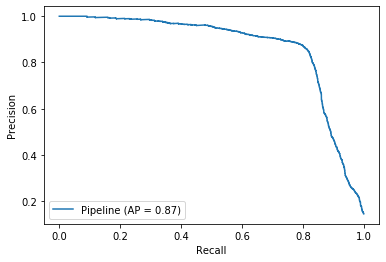

In [48]:
def model_evaluation(model, x, y, thresh=None):
    
    y_pred_prob = model.predict_proba(x)[:,1]
    assert(len(y_pred_prob) == len(y))

    precision, recall, thresholds = precision_recall_curve(y, y_pred_prob)
    aucpr = auc(recall, precision)
    roc = roc_auc_score(y, y_pred_prob)
    
    if thresh:
        i = np.where(recall >= thresh)[0][-1]
        y_pred = [1 if j >= thresholds[i] else 0 for j in y_pred_prob]
        f1 = f1_score(y, y_pred)
        conf = confusion_matrix(y, y_pred)
        stat = pd.DataFrame({'Precision': [precision[i]], 'Recall':[recall[i]],
                             'AUCPR': [aucpr], 'ROC': [roc], 'F1':f1, 'Threshold': thresholds[i]})
        print(stat)
        print(conf)
    else:
        stat = pd.DataFrame({'AUCPR': [aucpr], 'ROC': [roc]})
        
        print(stat)
        
        return recall
    
# extract the best parameters
best_param = {}
for i in grid_clf.best_params_.keys():
    best_param[i.replace('classifier__', '')] = grid_clf.best_params_[i]
    
# retrain model
clf.steps[1][1].set_params(**best_param)
clf.fit(X_train, y_train)
plot_precision_recall_curve(clf, X_train, y_train)

In [49]:
print('Training Set Evaluation')
model_evaluation(clf, X_train, y_train, thresh=0.82)

print('Testing Set Evaluation')
model_evaluation(clf, X_test, y_test, thresh=0.82)

Training Set Evaluation
   Precision    Recall     AUCPR      ROC        F1  Threshold
0   0.847511  0.820294  0.866856  0.95124  0.833681   0.496822
[[18624   432]
 [  526  2401]]
Testing Set Evaluation
   Precision    Recall     AUCPR       ROC        F1  Threshold
0    0.84019  0.820711  0.850851  0.944726  0.830336   0.495216
[[7926  202]
 [ 232 1062]]


### Summary

* To find the most common medications for each disease, I selected those who have been diagnosed for each disease, and joined with the medication table by patient ID  to select the highest counts of medications for each disease.
* To find the most indicative of each disease, I realized some medications are too common to use, so picking the highest counts of medications missed the specificity. Therefore, I created two metrics: percentage of medication usage and tf-idf.
$$\% medication-usage = \frac{n(disease, medications)}{n(medications)}$$
$$tf-idf = n(disease, medications) * log[1 + \frac{n(disease)}{n(medications)}]$$
* First of all, I collected all diabetes patient records and their medications information. A list of top 100 common medications for diabetes was created by analyzing diabetes patients. I constructed a tree-based classification model (random forest) to identify whether new patients are diabetes based on the medications. My model has hundreds of input predictors, involving the patient demographics and usage of common diabetes medications. Then, I set up the 5-folder cross validation to train and tune 5 hyper-parameters of a random forest model in order to minimize the average precision metric. Lastly, evaluating the model performance in the testing set is showing a few metrics: precision, recall, AUCPR and F1. Based on the evaluation metrics, my model has 84% confident accuracy on the predictions, and 82% true diabetes patients will be effectively detected in our predictions.